# Inverse problem for the diffusion equation
## DeepXDE demo:
https://github.com/lululxvi/deepxde/blob/master/examples/pinn_inverse/diffusion_1d_inverse.py

In [1]:
import deepxde as dde
import numpy as np
from deepxde.backend import tf
import tensorflow as tf
import torch

Using backend: pytorch
Other supported backends: tensorflow.compat.v1, tensorflow, jax, paddle.
paddle supports more examples now and is recommended.


## Problem setup
We will solve an inverse problem for the diffusion equation with an unknown parameter 
:

 
 
with the initial condition

and the Dirichlet boundary condition

The reference solution is 
.

## We begin by defining computational geometries
We can use a built-in class Interval and TimeDomain and we combine both the domains using GeometryXTime as follows

In [5]:
geom = dde.geometry.Interval(-1, 1)
timedomain = dde.geometry.TimeDomain(0, 1)
geomtime = dde.geometry.GeometryXTime(geom, timedomain)

## Express the PDE residual of the diffusion equation:
- The first argument to pde is 2-dimensional vector where the first component(x[:,0:1]) is 
x-coordinate and the second component (x[:,1:]) is the 
t-coordinate. 
- The second argument is the network output, i.e., the solution y(x,t) 
-C is an unknown tunable parameter with initial value 2.0

In [2]:
C = dde.Variable(2.0)

def pde(x, y):
    dy_t = dde.grad.jacobian(y, x, i=0, j=1)
    dy_xx = dde.grad.hessian(y, x, i=0, j=0)
  
    return (
        dy_t
        - C * dy_xx
        + torch.exp(-x[:, 1:])
        * (torch.sin(np.pi * x[:, 0:1]) - np.pi ** 2 * torch.sin(np.pi * x[:, 0:1]))
    )

## The boundary/initial conditions
- on_boundary is chosen here to use the whole boundary of the computational domain in considered as the boundary condition. 
- We include the geotime space , time geometry created above and on_boundary as the BC in the DirichletBC function of DeepXDE. 
- We also define IC which is the initial condition for the diffusion equation and we use the computational domain, initial function, and on_initial to specify the IC.

In [3]:
def func(x):
    return np.sin(np.pi * x[:, 0:1]) * np.exp(-x[:, 1:])

In [6]:
bc = dde.icbc.DirichletBC(geomtime, func, lambda _, on_boundary: on_boundary)
ic = dde.icbc.IC(geomtime, func, lambda _, on_initial: on_initial)

## Generate "observation" data
In this problem, we provide extra information on some training points, and the parameter 
 C can be identified from these observations. 
 - We generate a 2-dimensional array observe_x of 10 equally-spaced input points (x,t) as the first argument to PointSetBC, where X is in [-1,1] and t = 1. 
- The second argument func(observe_x) is the corresponding exact solution. PointSetBC compares observe_x and func(observe_x), and they satisfy the Dirichlet boundary condition.

In [7]:
observe_x = np.vstack((np.linspace(-1, 1, num=10), np.full((10), 1))).T
observe_y = dde.icbc.PointSetBC(observe_x, func(observe_x), component=0)

## Define the TimePDE problem as:
- num_domain=40   is the number of training residual points sampled inside the domain
- num_boundary=20   is the number of training points sampled on the boundary (the left and right endpoints of the interval). 
- num_initial=10   include 10 initial residual points for the initial conditions
- num_test=10000   points for testing the PDE residual. 
- anchors=observe_x   is the above described training points in addition to the num_domain, num_initial, and num_boundary sampled points.

In [8]:
data = dde.data.TimePDE(
    geomtime,
    pde,
    [bc, ic, observe_y],
    num_domain=40,
    num_boundary=20,
    num_initial=10,
    anchors=observe_x,
    solution=func,
    num_test=10000,
)

## Set the network
Here, we use a fully connected neural network of depth 4 (i.e., 3 hidden layers) and width 32

In [9]:
layer_size = [2] + [32] * 3 + [1]
activation = "tanh"
initializer = "Glorot uniform"
net = dde.nn.FNN(layer_size, activation, initializer)

## Build the Model
- choose the optimizer and learning rate
- the unknown parameter C is passed as external_trainable_variables:

In [10]:
model = dde.Model(data, net)
model.compile("adam", lr=0.001, metrics=["l2 relative error"], external_trainable_variables=C)

Compiling model...
'compile' took 0.559951 s



## Train the model
- 50000 iterations
- Output the value of C every 1000 iterations:

In [11]:
variable = dde.callbacks.VariableValue(C, period=1000)
losshistory, train_state = model.train(iterations=50000, callbacks=[variable])

Training model...

Step      Train loss                                  Test loss                                   Test metric   
0         [1.38e+01, 9.33e-02, 3.37e-01, 4.67e-02]    [1.62e+01, 9.33e-02, 3.37e-01, 4.67e-02]    [7.63e-01]    
0 [2.00e+00]
1000      [4.36e-03, 1.57e-02, 4.46e-02, 1.27e-02]    [4.90e-03, 1.57e-02, 4.46e-02, 1.27e-02]    [4.03e-01]    
1000 [1.94e+00]
2000      [2.03e-03, 4.33e-03, 8.96e-03, 7.40e-03]    [4.62e-03, 4.33e-03, 8.96e-03, 7.40e-03]    [3.88e-01]    
2000 [1.67e+00]
3000      [9.26e-04, 1.16e-03, 1.43e-03, 3.59e-03]    [1.87e-03, 1.16e-03, 1.43e-03, 3.59e-03]    [2.64e-01]    
3000 [1.38e+00]
4000      [2.93e-04, 3.92e-04, 4.00e-05, 7.90e-04]    [9.83e-04, 3.92e-04, 4.00e-05, 7.90e-04]    [1.18e-01]    
4000 [1.14e+00]
5000      [1.63e-04, 1.48e-04, 4.53e-06, 1.10e-04]    [6.04e-04, 1.48e-04, 4.53e-06, 1.10e-04]    [4.12e-02]    
5000 [1.05e+00]
6000      [1.37e-04, 6.57e-05, 3.67e-06, 2.12e-05]    [3.83e-04, 6.57e-05, 3.67e-06, 2.12e-05]   

Saving loss history to /Users/imriaharoni/Library/CloudStorage/GoogleDrive-imri.aharoni@gmail.com/My Drive/Office/DSRC/Courses and Workshops/PINN_Workshop/PINN_Workshop_Code/DeppXDE/loss.dat ...
Saving training data to /Users/imriaharoni/Library/CloudStorage/GoogleDrive-imri.aharoni@gmail.com/My Drive/Office/DSRC/Courses and Workshops/PINN_Workshop/PINN_Workshop_Code/DeppXDE/train.dat ...
Saving test data to /Users/imriaharoni/Library/CloudStorage/GoogleDrive-imri.aharoni@gmail.com/My Drive/Office/DSRC/Courses and Workshops/PINN_Workshop/PINN_Workshop_Code/DeppXDE/test.dat ...


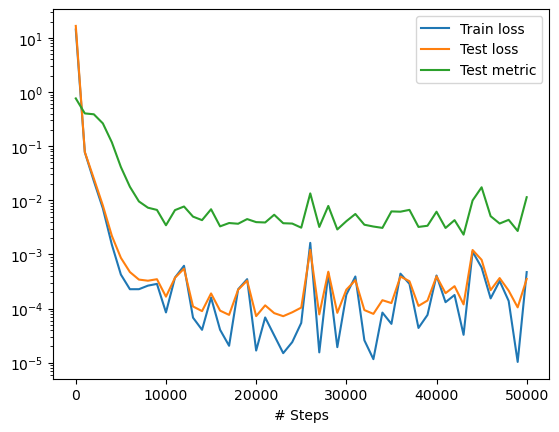

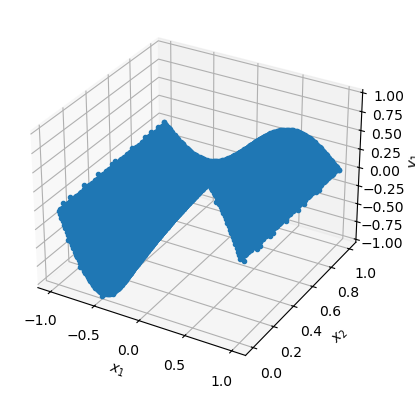

In [12]:
dde.saveplot(losshistory, train_state, issave=True, isplot=True)